In [1]:
from netCDF4 import Dataset
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
try:
    lats = np.load("lats.npy")
    lons = np.load("lons.npy")
except:
    files = glob.glob("data/aoml/**/*.nc", recursive=True)
    print(len(files))

    lats = []
    lons = []

    for f in tqdm(files):
        d = Dataset(f)
        lat = d.variables["LATITUDE"][:]
        lon = d.variables["LONGITUDE"][:]
        lats.extend(lat)
        lons.extend(lon)
        #temps = d.variables["TEMP_ADJUSTED"]

    np.save("lats", lats)
    np.save("lons", lons)

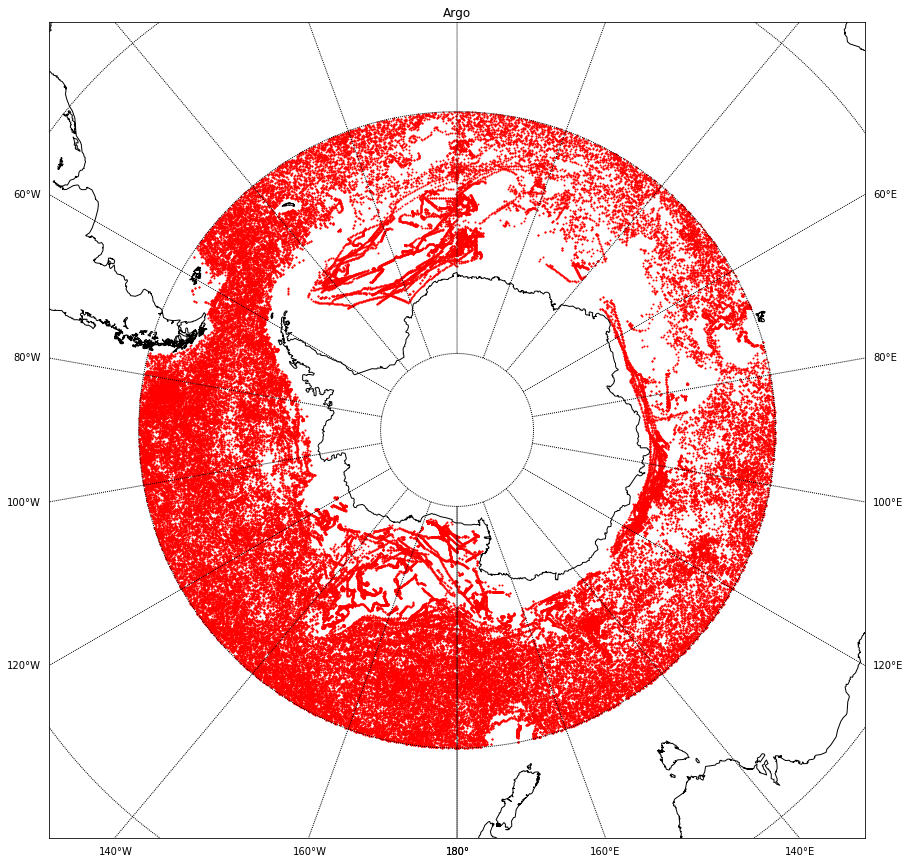

In [4]:
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-40,lon_0=180,resolution='l')
m.drawcoastlines()
#m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-50, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
plt.title("Argo")
#x, y = m(lons, lats)
#heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
#m.imshow(heatmap.T, interpolation='bicubic', cmap="Reds")
m.scatter(lons, lats, latlon=True, s=1,c='r',alpha=1)
plt.show()